# Tyylin siirtäminen kuvasta toiseen
## Tavoitteet
Tarkoituksena on ottaa tyyli jostain referenssikuvasta, kuten maalauksesta, ja siirtää siitä piirteitä toiseen kuvaan. 

In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    print(e)

2 Physical GPUs, 2 Logical GPUs


## Datan kuvaus
Datana käytämme kuvia, tässä tapauksessa esimerkkikuvina toimivat kuva lumivuoresta sekä värikäs maalaus aurinkoisesta mäestä. Kun kuvat on ladattu asetamme korkeudeksi `400`, jonka perusteella laskemme leveyden, jotta kuvasuhde säilyy samana.

In [2]:
from tensorflow import keras
  
base_image_path = keras.utils.get_file(
    "mountains.jpg", origin="https://www.worldatlas.com/r/w1200/upload/56/fb/ee/alaska-mountain-range-csnafzger.jpg")
style_reference_image_path = keras.utils.get_file(
    "art2.jpg", origin="https://img.freepik.com/premium-vector/stylized-abstract-painting-decorative-landscape_858664-44720.jpg")
  
original_width, original_height = keras.utils.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

## Datan esikäsittely
Määritämme funktion kuvien esiprosessoimiselle. Kuva muutetaan numeroiksi `preprocess_image`-funktiossa. `deprocess_image`-funktio muuttaa numeroista koostuvan kuvan takaisin tavalliseksi kuvaksi.

`deprocess_image` funktion ensimmäiset 3 riviä summa laskuja toteuttavat `zero-centering` operaation, joka peruuttaa `vgg19` tekemän transformaation input kerroksessa. Laskujen jälkeinen (`img[:, :, ::-1]`) rivi muuttaa kuvan värikanavat `BGR` järjestyksestä `RGB`:hen.

In [3]:
import numpy as np
  
def preprocess_image(image_path):
    img = keras.utils.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.utils.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img
  
def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

## Mallinnus
Käytämme valmiiksi koulutettua `VGG19`-mallia, jotta saamme kuvista tyylin ja sisällön eroteltua.

In [4]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)
  
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

Määritetään `content_loss` funktio joka, laskee sisältöhäviöitä kuville. Funktiolle syötetään parametreina alkuperäinen kuva, sekä yhdistetty kuva.

In [5]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

`Gram-matriisi` on tärkeä osa tyylihäviön laskemista. Funktio laskee kuvassa olevien piirteiden väliset suhteet ja tekee niistä gram-matriisin jota käytetään tyylihäviön laskemiseen.

`style_loss`-funktiolla saamme laskettua häviömitan käyttämällä `gram_matrix`-funktiosta saatuja gram-matriiseja. Häviömitalla saamme tietää kuinka paljon kuvat muistuttavat toisiaan.

In [6]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram
  
def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

Viimeiseksi tehdään funktio, joka laskee kokonaisvaihteluhäviötä. Tämä arvo auttaa meitä välttämään kuvien liiallista pikselöitymistä ja epätasaisuutta. Toisinsanoen tämä tekee kuvista "sulavempia".

In [7]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

Seuraavaksi määritämme häviö-funktion, joka vertailee eroja luodun-, alkuperäisen-, sekä tyyli-kuvan välillä. Funktio palauttaa lopuksi häviöarvon.

In [8]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8
  
def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
            style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value
  
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

Seuraavassa koodisolussa toteutamme tyylinsiirtoalgoritmin, jolla optimoidaan yhdistelmäkuvaa käyttämällä gradienttilaskentaa ja eksponentiaalisen heikkenemisen optimointia (SGD), toistamalla prosessia tuhansia kertoja ja tallentamalla välitulokset kuvatiedostoina.

In [9]:
import tensorflow as tf
  
@tf.function
def compute_loss_and_grads(
    combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(
            combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads
  
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96 
    )
)
  
base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))
  
iterations = 4000 
for i in range(1, iterations + 1): 
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png" 
        keras.utils.save_img(fname, img) 

Iteration 100: loss=5329.88
Iteration 200: loss=3804.84
Iteration 300: loss=3255.97
Iteration 400: loss=2963.32
Iteration 500: loss=2776.11
Iteration 600: loss=2643.47
Iteration 700: loss=2544.06
Iteration 800: loss=2465.94
Iteration 900: loss=2402.81
Iteration 1000: loss=2350.45
Iteration 1100: loss=2306.23
Iteration 1200: loss=2268.31
Iteration 1300: loss=2235.31
Iteration 1400: loss=2206.25
Iteration 1500: loss=2180.41
Iteration 1600: loss=2157.31
Iteration 1700: loss=2136.52
Iteration 1800: loss=2117.77
Iteration 1900: loss=2100.74
Iteration 2000: loss=2085.20
Iteration 2100: loss=2070.95
Iteration 2200: loss=2057.86
Iteration 2300: loss=2045.77
Iteration 2400: loss=2034.62
Iteration 2500: loss=2024.30
Iteration 2600: loss=2014.70
Iteration 2700: loss=2005.78
Iteration 2800: loss=1997.45
Iteration 2900: loss=1989.67
Iteration 3000: loss=1982.38
Iteration 3100: loss=1975.55
Iteration 3200: loss=1969.14
Iteration 3300: loss=1963.13
Iteration 3400: loss=1957.47
Iteration 3500: loss=19

Voimme nyt tarkastella muutamia eri kuvia joita olemme syöttäneet mallin läpi.

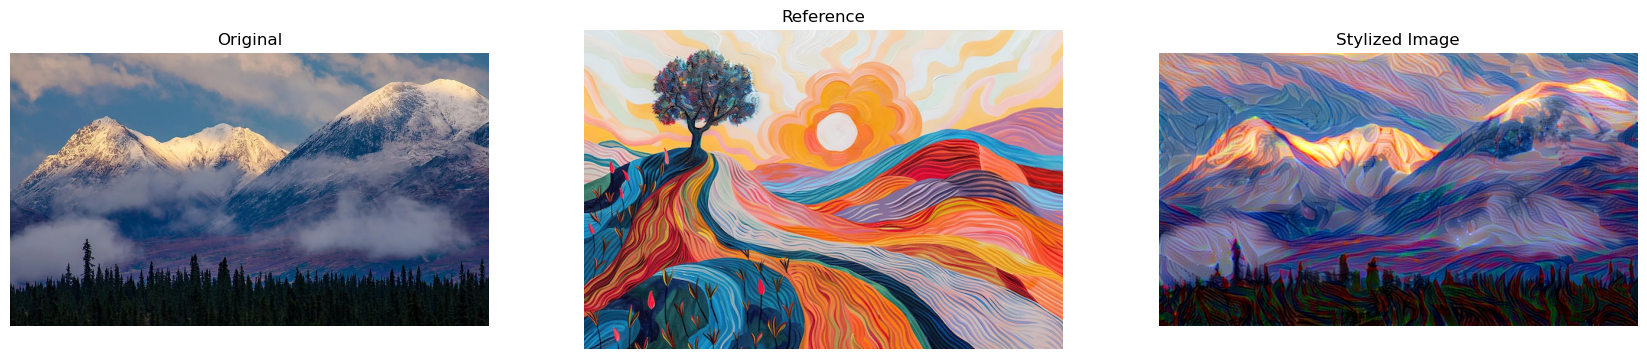

In [10]:
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib import gridspec

def show_n(images, titles=('',)):
  n = len(images)
  image_sizes = [400, 400, 400]
  w = (image_sizes[0] * 6) // 320
  plt.figure(figsize=(w * n, w))
  gs = gridspec.GridSpec(1, n, width_ratios=image_sizes)
  for i in range(n):
    plt.subplot(gs[i])
    plt.imshow(images[i], aspect='equal')
    plt.axis('off')
    plt.title(titles[i] if len(titles) > i else '')
  plt.show()

mountain_orig = Image.open("image_sets/mountains/original.jpg")
reference_1 = Image.open("image_sets/mountains/reference.jpg")
mountain_stylized = Image.open("image_sets/mountains/stylized-4000.png")
show_n([mountain_orig, reference_1, mountain_stylized], titles=["Original", "Reference", "Stylized Image"])

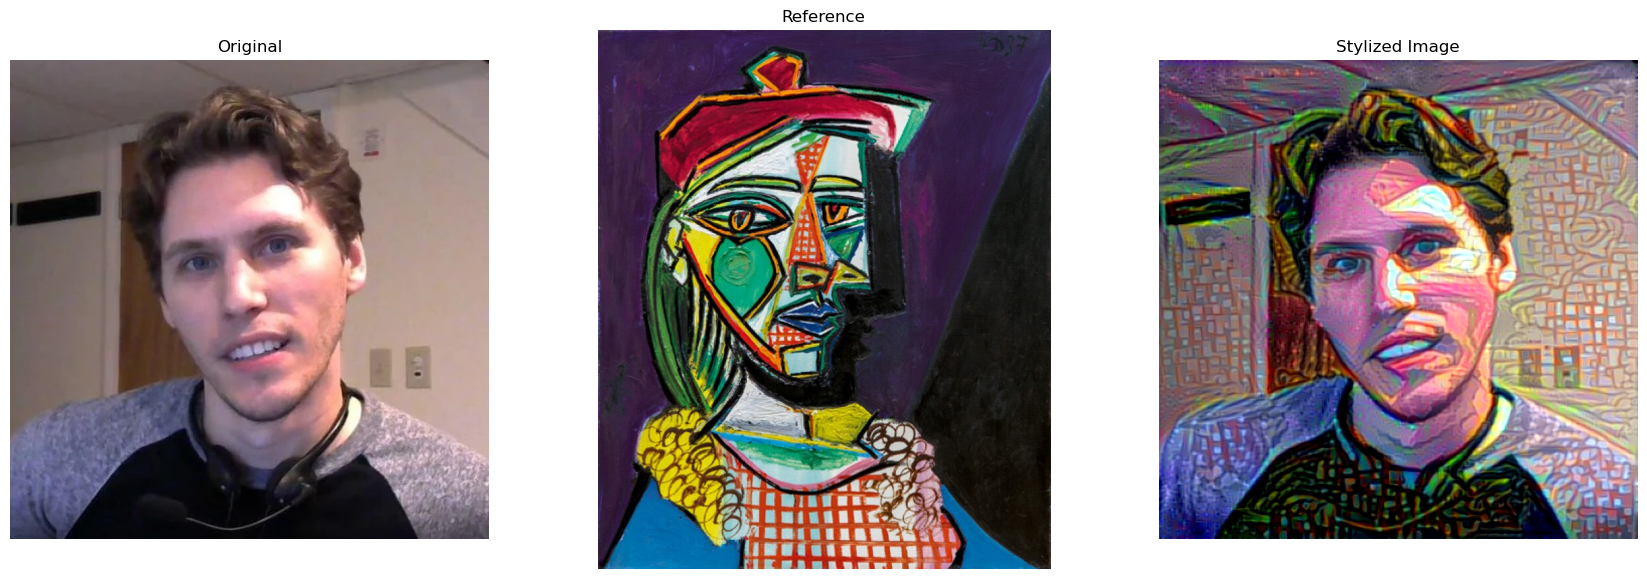

In [11]:
jerma_orig = Image.open("image_sets/jerma-picasso/original.webp")
reference_2 = Image.open("image_sets/jerma-picasso/reference.png")
jerma_stylized = Image.open("image_sets/jerma-picasso/stylized-4000.png")
show_n([jerma_orig, reference_2, jerma_stylized], titles=["Original", "Reference", "Stylized Image"])

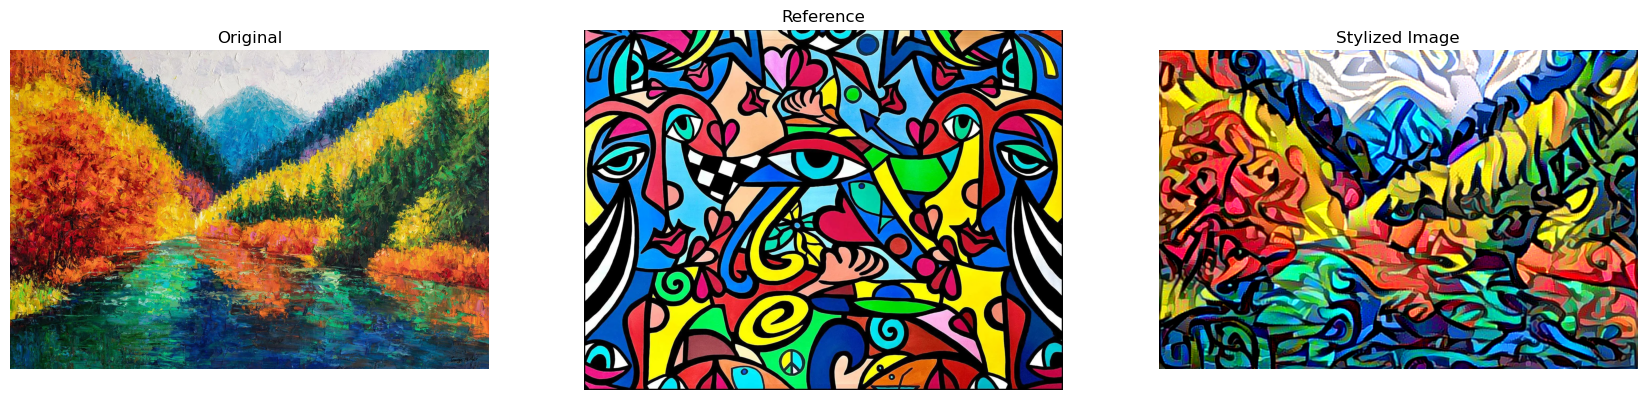

In [12]:
forest_orig = Image.open("image_sets/forest/original.jpg")
reference_3 = Image.open("image_sets/forest/reference.jpeg")
forest_stylized = Image.open("image_sets/forest/stylized-4000.png")
show_n([forest_orig, reference_3, forest_stylized], titles=["Original", "Reference", "Stylized Image"])

## Arviointi
Osa kuvista on tyylittynyt paljon hienomman näköisiksi kuin toiset. Huomasimme eri kuvia tyylitellessä maisemakuvien olevan usein parhaita valintoja tämän mallin toiminnan kannalta. Itse tyylikuvina oli parasta käyttää hyvin tyyliteltyjä kuvia, kuten **Pablo Picasson** tai **Vincent van Goghin** maalauksia. Jos kuvat valitsee hyvin, malli tuottaa hienon näköisiä tuloksia, kuten ensimmäisessä esimerkkikuvassa näkyy.

## Käyttöönotto
Tätä mallia voisi käyttää tyyliteltyjen kuvien tekemiseen, kuten olemme sitä käyttäneet.